# КОСМИЧЕСКИЕ БРАТЬЯ

## Материалы

[Презентация] https://disk.yandex.ru/i/nCtmTabymZg0ig 

[Дашборд] https://public.tableau.com/authoring/Cosmic_brothers/Dashboard1#1


## Описание проекта

Для новой мобильной игры Космические братья нужно проанализировать поведение игроков (какие стратегии игры выбирают, какие объекты строят, сколько времени проводят в игре...). Предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.

В датасете представлены данные по игре пользователей на первом уровне. **Завершение первого уровня** требует от игрока выполнения одного из двух условий:
* **Победа над первым врагом**
* **Реализация проекта - разработка орбитальной сборки спутников**

### Описание данных
*удалено по требованиям правообладателя*

### Задачи

***Исследование - Проанализируйте поведения игроков в зависимости от источника перехода.***
1. Проведите исследовательский анализ данных;
2. Проанализируйте влияние источника перехода в игру на поведение пользователя;
3. Проверьте гипотезу: ***время завершения уровня различается в зависимости способа прохождения***:
* через реализацию проекта,
* через победу над первым игроком.
4. Сформулируйте ***собственную статистическую гипотезу***. Дополните её нулевой и альтернативной гипотезами. Проверьте гипотезу с помощью статистического теста.
5. Проанализируйте возможности размещения рекламы при постройке объектов
***По итогам исследования подготовьте*** 
* ***презентацию***, в формате pdf 
* ***дашборд:*** *(выбрала только один набор для дашборда)*
    1. Диаграмма распределения количества построенных объектов
    2. Добавьте индикатор количества пользователей
    3. Добавьте фильтр дашборда по признаку завершения уровня

## Загрузка и предобработка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
pd.set_option('display.float_format', '{:,.2f}'.format)
import warnings
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')
import numpy as np
import scipy.stats as stats
import math
import itertools

### cost

In [2]:
try: 
    cost = pd.read_csv('/datasets/ad_costs.csv')
except:
    cost = pd.read_csv('ad_costs.csv')
    
def first(df):
    return display(df.head()), display(df.info())
                                        
first(cost)

,source,day,cost
0,facebook_ads,2020-05-03,935.88
1,facebook_ads,2020-05-04,548.35
2,facebook_ads,2020-05-05,260.19
3,facebook_ads,2020-05-06,177.98
4,facebook_ads,2020-05-07,111.77


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


None

(None, None)

In [3]:
#смотрим уникальные значения в столбце - варианты источников
cost['source'].unique()

array(['facebook_ads', 'instagram_new_adverts', 'yandex_direct',
       'youtube_channel_reklama'], dtype=object)

In [4]:
#cмотрим в какие даты привлекались пользователи
cost['day'].unique()

array(['2020-05-03', '2020-05-04', '2020-05-05', '2020-05-06',
       '2020-05-07', '2020-05-08', '2020-05-09'], dtype=object)

In [5]:
#проверяем, есть ли дубликаты
cost[cost.duplicated(keep = False)] 

,source,day,cost


In [6]:
#переводим дату в формат datetime
cost['day'] = pd.to_datetime(cost['day']).dt.date

Клиенты привлекались по четырем источникам в течение недели с 3 мая по 9 мая включительно. Всего в датасете 28 строк (4 источников * 7 дней). Пропусков и дубликатов нет.

### game

In [7]:
try: 
    game = pd.read_csv('/datasets/game_actions.csv')
except:
    game = pd.read_csv('game_actions.csv')
    
def first(df):
    return display(df.head()), display(df.info())
                                        
first(game)

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


None

(None, None)

In [8]:
#смотрим варианты событий
game['event'].unique()

array(['building', 'finished_stage_1', 'project'], dtype=object)

In [9]:
#cмотрим варианты строений
game['building_type'].unique()

array(['assembly_shop', 'spaceport', nan, 'research_center'], dtype=object)

In [10]:
#варианты заполнения project_type, в нем больше всего пропусков
game['project_type'].unique()

array([nan, 'satellite_orbital_assembly'], dtype=object)

In [11]:
#проверяем, есть ли дубликаты
game[game.duplicated(keep = False)] 

,event_datetime,event,building_type,user_id,project_type
74890,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN


In [12]:
#удаляем дубликаты
game = game.drop_duplicates().reset_index(drop = True)

In [13]:
#переводим в формат datetime, нам нужна только дата
game['date'] = pd.to_datetime(game['event_datetime']).dt.date

In [14]:
#минимальная дата
game['date'].min()

datetime.date(2020, 5, 4)

In [15]:
#максимальная дата
game['date'].max()

datetime.date(2020, 6, 5)

Всего в таблице 135640 строк. Cтрока - это действие совершенное юзером (или event). Представлена деятельность привлеченных юзеров в течение месяца. С 4 мая по 5 июня. 

Пропуски в building_type oзначают, что это действие юзера - не строительство. Делать с ними ничего не будем. 

Пропуски в project_type означают, что действие совершенное юзером - это не завершение проекта. Т.е. этот столбец заполнен, если event = project. Тоже с ними делать ничего не будем. 

### source

In [16]:
try: 
    source = pd.read_csv('/datasets/user_source.csv')
except:
    source = pd.read_csv('user_source.csv')
    
def first(df):
    return display(df.head()), display(df.info())
                                        
first(source)

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


None

(None, None)

In [17]:
#удостоверились, что те же самые источники
source['source'].unique()

array(['facebook_ads', 'yandex_direct', 'youtube_channel_reklama',
       'instagram_new_adverts'], dtype=object)

In [18]:
#нет дубликатов
source[source.duplicated(keep = False)] 

,user_id,source


In [19]:
# удостоверились, что один юзер - один источник
source['user_id'].nunique()

13576

In [20]:
#удостоверились, что данные по тем же самым юзерам, что и в датасете game
source[~source['user_id'].isin(game['user_id'])]

,user_id,source


### Вывод
Датасеты готовы к анализу

## Исследовательский анализ данных

### Длительность прохождения первого уровня 
<a class="anchor" id="MU"></a>

In [21]:
#создаем сводную таблицу, сгруппированную по user_id, 
#в building будет дата, когда юзер начал играть
#в finished_stage_1 - дата прохождения первого уровня
#в project - дата окончание проекта.
user = game.pivot_table(index='user_id', columns='event', \
                        values='date', aggfunc='first')
user = user.merge(source, on='user_id') #присоединили данные об источнике
user['time'] = user['finished_stage_1'] - user['building'] #время прохождения первого уровня
user.head()

,user_id,building,finished_stage_1,project,source,time
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06,NaN,NaN,facebook_ads,NaT
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06,NaN,NaN,yandex_direct,NaT
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05,NaN,NaN,youtube_channel_reklama,NaT
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05,2020-05-12,NaN,instagram_new_adverts,7 days
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05,NaN,NaN,facebook_ads,NaT


Если первый уровень пройден посредством завершения проекта - будет заполнен столбец project. 

Если finished_stage_1 заполнен и не заполнен project - уровень пройден посредством победы. 

В остальных случаях уровень не пройден.

In [22]:
#pd.Series с длительностью прохождения уровня, выбравших стартегию победы
list_victory = user[(~user['time'].isna()) & (user['project'].isna())].set_index('user_id')['time'].dt.days
print('медианное время - стратегия победы:', list_victory.median())

медианное время - стратегия победы: 11.0


In [23]:
#pd.Series с длительностью прохождения уровня, выбравших стартегию завершение проекта
list_project = user[(~user['project'].isna())].set_index('user_id')['time'].dt.days
print('медианное время - cтратегия реализации проекта:', list_project.median())

медианное время - cтратегия реализации проекта: 13.0


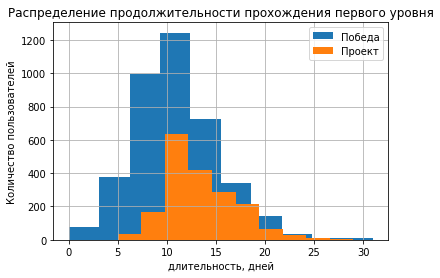

In [24]:
#гистограмма прохождения первого уровня, в зависимости от выбранной стратегии
#на этом графике количество пользовтелей по оси у абсолютное, поэтому можно сравнить размер двух групп
ax = list_victory.hist(bins = 10)
list_project.hist(ax=ax, bins = 10)
plt.title('Распределение продолжительности прохождения первого уровня')
plt.legend(['Победа', 'Проект'])
plt.xlabel('длительность, дней')
plt.ylabel('Количество пользователей');

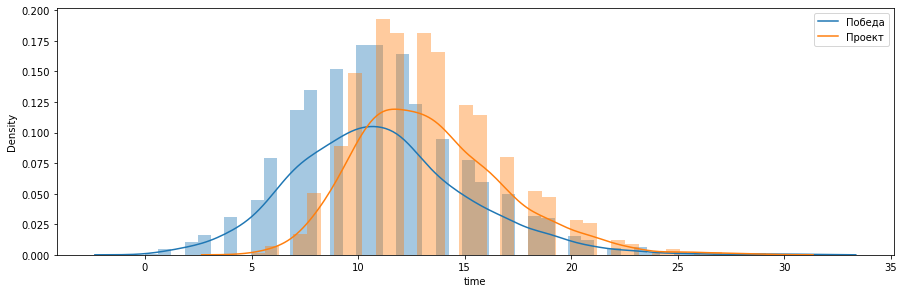

In [25]:
#плотность распределения продолжительности в зависимости от выбранной стратиегии
#сравниваем характер распределения 
plt.figure(figsize = (15,10))
sns.distplot(list_victory, ax = plt.subplot(2, 1, 1))
sns.distplot(list_project, ax = plt.subplot(2, 1, 1))
plt.legend(['Победа', 'Проект']);

In [26]:
q = round(list_victory.count()/list_project.count())
print(f'Выбравших стратегию победы в {q} раза больше, чем выбравших проект') 

Выбравших стратегию победы в 2 раза больше, чем выбравших проект


**Вывод.** Получается, что стратегия выполнения проекта удлиняет время прохождения на два дня. (Насколько эта разница статистически значима, проверим с помощью статистического теста в следующем [разделе](#time)). При этом тех, кто выбрал стратегию проекта в два раза меньше, чем выбравших стратегию победы. Можно сделать вывод о том, что пройти первый уровень победив другого участника проще, чем выполнив проект.

### Среднее время проведенное в игре

Длительность прохождения уровня мы уже проанализировали. Но в целом тех, кто вообще прошел уровень меньше половины. Давайте посмотрим, сколько дней в целом пользователь проводит в игре, в независимости от его успешности.

*(Так как у нас нет данных по началу и окончанию сессии, есть только момент времени совершения определенного действия, мы не можем посчитать сколько времени (в часах, минутах) игрок проводит в игре. Можем только отследить период в днях и количество действий.
*  

In [27]:
#сгруппируем по юзеру и найдем первую и последнюю дату, когда игрок совершал действия.
user_all = game.groupby('user_id').agg({'date' : ['min' , 'max']})
user_all.columns = ['first', 'last']
"""""длительность нахождения в игре, в днях посчитнана как период между первой и последней датой совершения действия 
по строительству. 
(допущение: в этот период будут входить и дни, когда объекты не строились, тк в эти дни игрок мог входить в игру 
 и совершать другие действия, не учитывающиеся в датасете)"""""
user_all['duration'] = (user_all['last'] - user_all['first']).dt.days 
user_all = user_all.merge(source, on='user_id')
list_all = user_all.set_index('user_id')#['duration'].dt.days
print('медианное время - все игроки:', list_all.median())

медианное время - все игроки: duration   10.00
dtype: float64


In [28]:
user_all.groupby('source').agg({'duration' : 'mean'})

,duration
source,
facebook_ads,10.68
instagram_new_adverts,10.75
yandex_direct,10.57
youtube_channel_reklama,10.55


В среднем все игроки активно проводят в игре 10 дней, в не зависимости от прохождения первого уровня. Источник не влияет на это время.

In [29]:
game.groupby('user_id').agg({'date' : 'nunique'}).merge(source, on='user_id').groupby('source').agg({'date' : 'mean'})

,date
source,
facebook_ads,7.09
instagram_new_adverts,7.07
yandex_direct,6.98
youtube_channel_reklama,6.93


In [30]:
#посчитаем время нахождения в игре для не прошедших первый уровень
user_churn = user_all.set_index('user_id')\
.query('index not in @list_victory.index and user_id not in @list_project.index')
list_churn = user_churn['duration']#.dt.days
print('медианное время - выбывшие игроки:', list_churn.median())

медианное время - выбывшие игроки: 10.0


Игроки, которые не прошли первый уровень также проводят в игре 10 дней (медиана). 

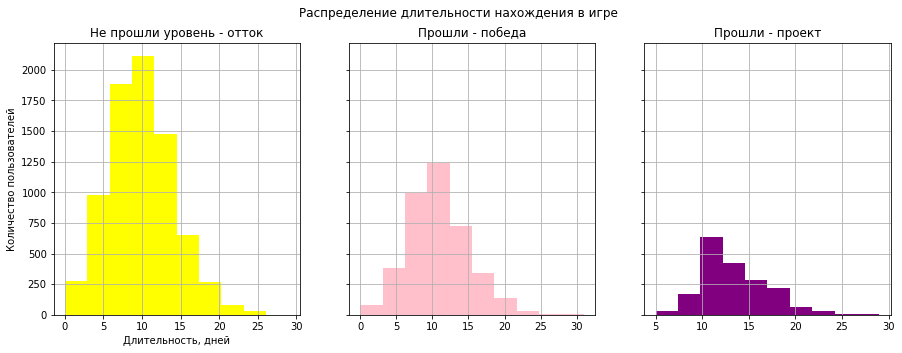

In [31]:
plt.figure(figsize = (15,5))
plt.suptitle('Распределение длительности нахождения в игре')
ax1 = plt.subplot(1, 3, 1)
list_churn.plot(kind='hist', grid=True, ax=ax1, color='yellow')
plt.ylabel('Количество пользователей')
plt.xlabel('Длительность, дней')
plt.title('Не прошли уровень - отток')
ax2 = plt.subplot(1, 3, 2, sharey=ax1)
list_victory.plot(kind='hist', grid=True, ax=ax2, color='pink', sharey=ax1)
plt.title('Прошли - победа')
ax3 = plt.subplot(1, 3, 3, sharey=ax1)
list_project.plot(kind='hist', grid=True, ax=ax3, color='purple', sharey=ax1)
plt.title('Прошли - проект');


Большинство игроков все-таки не проходят уровень, но довольно продолжительное время (в среднем(10 дней) находятся в игре и строят объекты. Этот факт можно использовать для монетизации - размещения рекламы в игре.

### Динамика активности пользователей
график <a class="anchor" id="chart"></a>

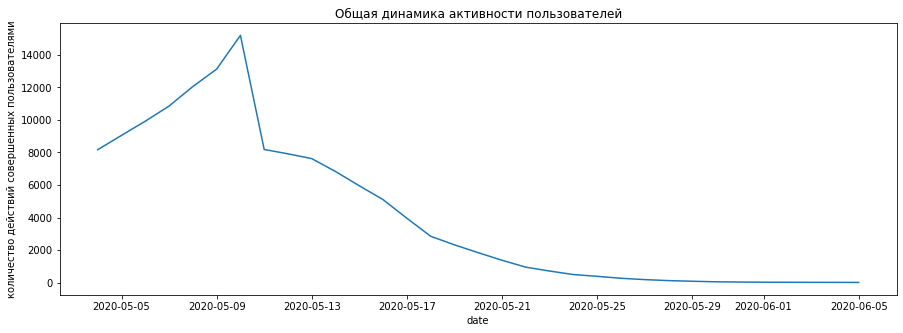

In [32]:
# общая динамика активности пользователей
game.groupby('date').agg({'user_id':'count'}).plot(figsize=(15,5), legend=False)
plt.title('Общая динамика активности пользователей')
plt.ylabel('количество действий совершенных пользователями');

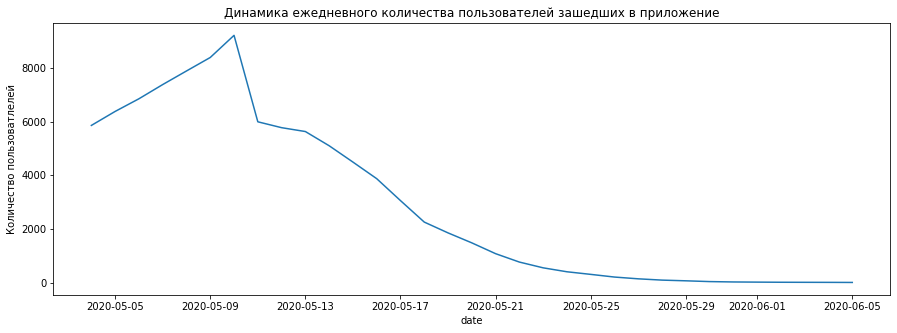

In [33]:
game.groupby('date').agg({'user_id':'nunique'}).plot(figsize=(15,5), legend=False)
plt.title('Динамика ежедневного количества пользователей зашедших в приложение')
plt.ylabel('Количество пользоватлелей');

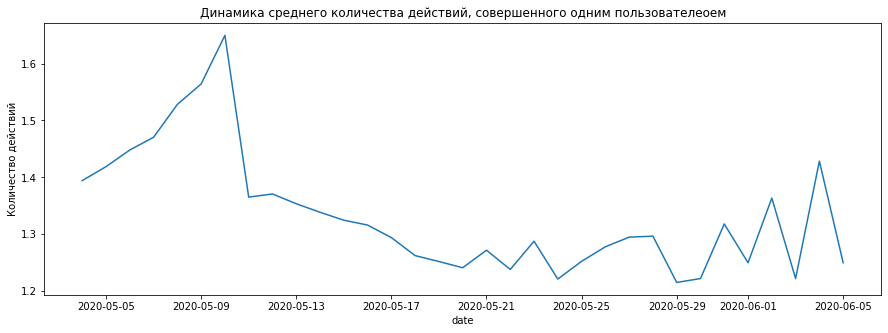

In [34]:
timing = game.groupby('date').agg({'user_id':['nunique', 'count']})
timing.columns = ['user', 'event']

# расчет среднего количества действий, совершенных 1 пользователем
timing['event_per_user'] = timing['event'] / timing['user']
timing['event_per_user'].plot(figsize=(15,5))
plt.title('Динамика среднего количества действий, совершенного одним пользователеоем')
plt.ylabel('Количество действий');

В первую неделю, когда были показы рекламы игры, мы видим увеличение числа юзеров. Впоследствии мы видим спад их количества. Средняя же активность одного юзера постоянна она колеблется от 1.6 до 1.2 действий в день. T.e.  есть небольшое количество пользователей, которые постоянно заходят в приложение и играют.

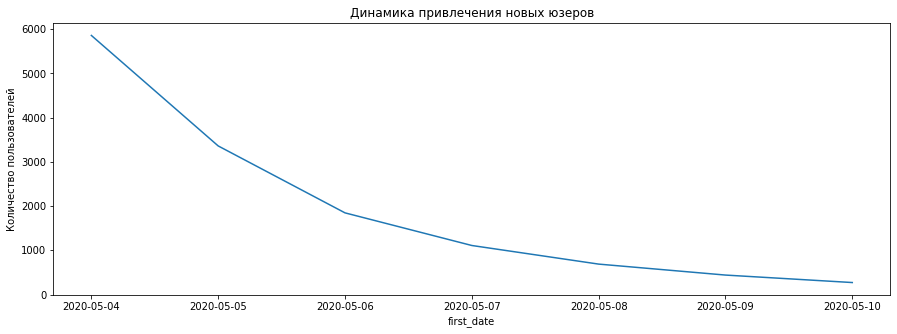

In [35]:
#посмотрим на динамика привлечения новых юзеров
#в 'building' отображается дата первого строительства объекта. Тк все игроки, в независимости 
#от стратегии строят. Будем считать эту дату - датой привлечения юзера
new_users = user.groupby('building').agg({'user_id' : 'count'})
new_users.plot(figsize=(15,5), legend=False)
plt.title('Динамика привлечения новых юзеров')
plt.xlabel('first_date')
plt.ylabel('Количество пользователей');

Новые игроки приходили только во время показа рекламы, и то мы под конец рекламной компании мы видим экспоненциальный спад их прихода. Видимо аудитория посмотрела рекламу в первые пару дней и решила заходить в игру или нет тогда же. 

### Среднея стоимость и количество привлеченных пользователей в динамике 

In [36]:
#сводная таблица для динамики стоимости привлечения и количества привлеченных юзеров
#c разбивкой по источникам
new_user_cost = user.groupby(['building', 'source'])\
.agg({'user_id' : 'count'}).reset_index().rename(columns={'building':'day'})
#объединяем количество юзеров со стоимостью
new_user_cost = new_user_cost.merge(cost, on= ['day', 'source'], how ='outer')
new_user_cost = new_user_cost.sort_values(by = 'day')
#рассчитываем стоимость привлечения одного юзера для каждого дня
new_user_cost['cost_per_user'] = new_user_cost['cost'] / new_user_cost['user_id']
new_user_cost

,day,source,user_id,cost,cost_per_user
31,2020-05-03,youtube_channel_reklama,NaN,454.22,NaN
29,2020-05-03,instagram_new_adverts,NaN,943.20,NaN
28,2020-05-03,facebook_ads,NaN,935.88,NaN
30,2020-05-03,yandex_direct,NaN,969.14,NaN
0,2020-05-04,facebook_ads,"1,184.00",548.35,0.46
1,2020-05-04,instagram_new_adverts,"1,452.00",502.93,0.35
2,2020-05-04,yandex_direct,"2,078.00",554.65,0.27
3,2020-05-04,youtube_channel_reklama,"1,146.00",259.07,0.23
5,2020-05-05,instagram_new_adverts,796.00,313.97,0.39
6,2020-05-05,yandex_direct,"1,208.00",308.23,0.26


In [37]:
#проверка - должно получится общее число уникальных пользователей
new_user_cost['user_id'].sum()

13576.0

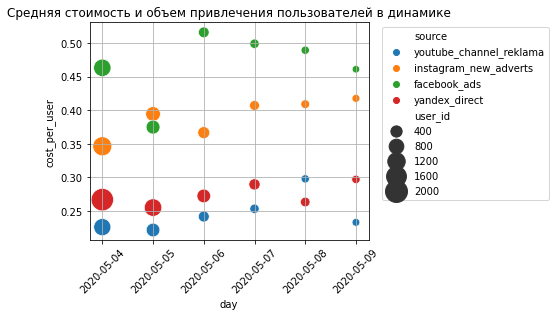

In [38]:
plt.figure(figsize=(5, 4))
sns.scatterplot(data=new_user_cost, x='day', y='cost_per_user', hue='source', size='user_id', sizes=(50, 500))
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(bbox_to_anchor= (1.03, 1) )
plt.title('Средняя стоимость и объем привлечения пользователей в динамике');

Мы видим, что почти у всех источников стоимость привлечения одного юзера немного растет в последние дни, а количество привлеченных юзеров наоборот уменьшается. Можно сделать вывод, что рекламная компания наиболее эффективна в первые дня три. 

*Еще, судя по сводной таблице выше можно сделать вывод, что существует лаг в 1 день. Т.е. стоимость кликов относится к 3 мая, но в этот день нет привлечения новых юзеров. И наоборот, в последний день 10 мая, есть новые юзеры, но нет оплаченных кликов. Для оценки этой закономерности мало данных, поэтому оставили как есть и первый и последний день не учитываем при построении графика.*

### Retention_rate в зависимости от источника

Для начала посмотрим в общем, как различаются источники по количеству привлеченных пользователей
<a class="anchor" id="chart-1"></a>

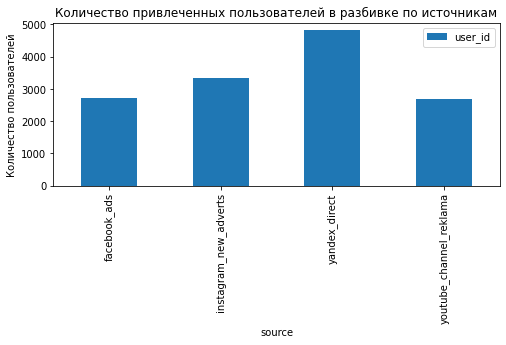

In [39]:
#сводная таблица, сколько источника привлекли уникальных пользователей
report = game.merge(source, on=['user_id'])
report.groupby('source').agg({'user_id' : 'nunique'}).plot(kind='bar', figsize=(8,3))
plt.title('Количество привлеченных пользователей в разбивке по источникам')
plt.ylabel('Количество пользователей');

И сделаем сводную таблицу средней стоимости привлечения одного пользователя в разбивке по источникам.

In [40]:
report_group = report.groupby('source').agg({'user_id' : 'nunique'}) #количество пользователей
cost_group = cost.groupby('source').agg({'cost' : 'sum'}) #стоимость привлечения
report_group = report_group.merge(cost_group, on='source')
#расчет стоимости привлечения одного пользователя
report_group['cost_per_user'] = report_group['cost'] / report_group['user_id']
report_group

,user_id,cost,cost_per_user
source,,,
facebook_ads,2726,"2,140.90",0.79
instagram_new_adverts,3347,"2,161.44",0.65
yandex_direct,4817,"2,233.11",0.46
youtube_channel_reklama,2686,"1,068.12",0.40


Источник **Yandex_direct** является лидером, он привлек больше всего пользователей и он один из самых дешевых. **Facebook_ads** намного дороже и привлек меньше всего пользователей

**Коэффициент удержания** <a class="anchor" id="retention"></a> (retention_rate) мы посчитаем как отношение количества игроков, прошедших первый уровень к общему количеству игроков. Мы увидели, что среднее время прохождения уровня это 11 - 13 дней в зависимости от стратегии. Данные у нас за месяц. Поэтому, можно сделать вывод, что если человек не прошел первый уровень за это время, значит он не заинтересовался игрой. Так же мы видим, что активность юзеров с течением времени значительно падает - люди или перестают играть, или переходят на другой уровень. 

In [41]:
#группируем по источникам
#'finished_stage_1' : 'count' - количество пользоватлей прошедших первый уровень
#'building' : 'count' - количество пользователей - всего
#'project' : 'count' - количество пользователей выполнивших проект
user_group = user.groupby('source')\
.agg({'finished_stage_1' : 'count',\
      'building' : 'count',\
      'project' : 'count'}) 
#доля прошедших первый уровень
user_group['retention'] = user_group['finished_stage_1'] / user_group['building']
#доля выбравших стратиеги победы
user_group['victory'] = (user_group['finished_stage_1'] - user_group['project'])/user_group['finished_stage_1']
#доля выбравших проект в прошедших первый уровень
user_group['strategy'] = user_group['project']/user_group['finished_stage_1']
display(user_group)
user_group_ratios = user_group[['retention', 'strategy']].merge(report_group['cost_per_user'], on='source')
user_group_ratios

,finished_stage_1,building,project,retention,victory,strategy
source,,,,,,
facebook_ads,1150,2726,391,0.42,0.66,0.34
instagram_new_adverts,1466,3347,476,0.44,0.68,0.32
yandex_direct,2042,4817,620,0.42,0.70,0.30
youtube_channel_reklama,1159,2686,379,0.43,0.67,0.33


,retention,strategy,cost_per_user
source,,,
facebook_ads,0.42,0.34,0.79
instagram_new_adverts,0.44,0.32,0.65
yandex_direct,0.42,0.30,0.46
youtube_channel_reklama,0.43,0.33,0.40


In [42]:
#проверка 
report_group['user_id'].sum() == user_group['building'].sum() == game['user_id'].nunique()

True

In [43]:
#проверка
report_group['cost'].sum() == cost['cost'].sum()

True

Кажется, что retention не зависит от выбора источника. Он колеблется от 42 до 43 процентов.  Насколько разница статистически значима, покажет [z-test](#z-test-1)

### Количество построеных объектов, в зависимости от выбранной стратегии
<a class="anchor" id="project_ratio"></a>

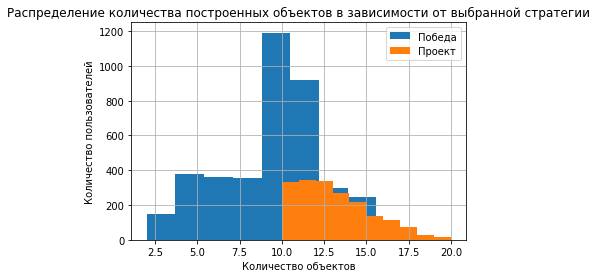

In [44]:
#количество объектов, тех, кто выбрал победу
build_victory = game.query('user_id in @list_victory.index').groupby('user_id')\
.agg({'building_type':'count'})

#количество объектов, тех, кто выбрал проект
build_project = game.query('user_id in @list_project.index').groupby('user_id')\
.agg({'building_type':'count'})

#количество объектов, тех, кто не прошел первый уровень
build_churn = game.query('user_id not in @list_victory.index and user_id not in @list_project.index')\
.groupby('user_id').agg({'building_type':'count'})

ax = build_victory.hist(bins = 10)
build_project.hist(ax=ax, bins = 10)
plt.title('Распределение количества построенных объектов в зависимости от выбранной стратегии')
plt.legend(['Победа', 'Проект'])
plt.xlabel('Количество объектов')
plt.ylabel('Количество пользователей');

На этом гарфике хорошо видно различие двух стратегий 

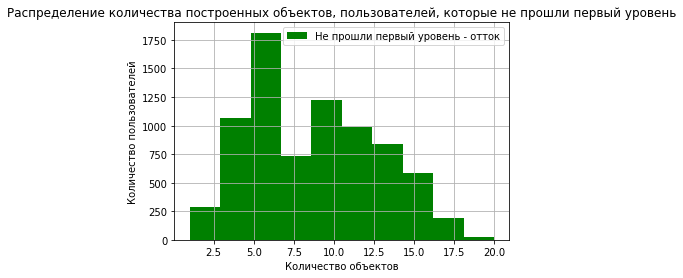

In [45]:
build_churn.hist(color='green')
plt.title('Распределение количества построенных объектов, пользователей, которые не прошли первый уровень')
plt.legend(['Не прошли первый уровень - отток'])
plt.xlabel('Количество объектов')
plt.ylabel('Количество пользователей');

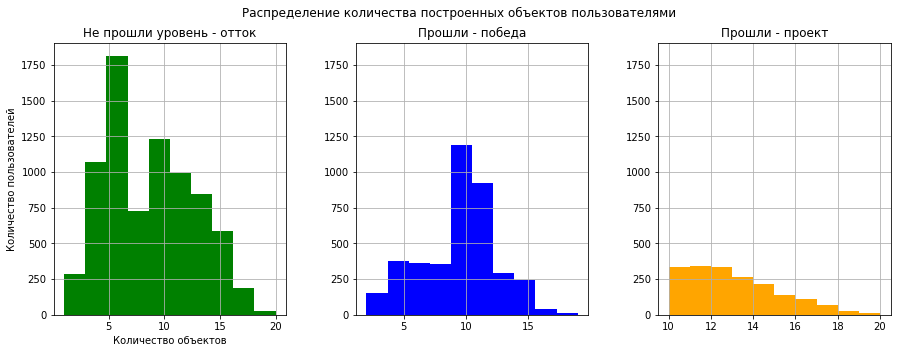

In [46]:
plt.figure(figsize = (15,5))
plt.suptitle('Распределение количества построенных объектов пользователями')
ax1 = plt.subplot(1, 3, 1)
build_churn.hist(grid=True, ax=ax1, color='green')
plt.ylabel('Количество пользователей')
plt.xlabel('Количество объектов')
plt.title('Не прошли уровень - отток')
ax2 = plt.subplot(1, 3, 2, sharey=ax1)
build_victory.hist(grid=True, ax=ax2, color='blue', sharey=ax1)
plt.title('Прошли - победа')
ax3 = plt.subplot(1, 3, 3, sharey=ax1)
build_project.hist(grid=True, ax=ax3, color='orange', sharey=ax1)
plt.title('Прошли - проект');

In [47]:
print('медианное количество построенных объектов')
print('\n')
print('не прошли уровень - отток:', build_churn.median())
print('прошли - победа:', build_victory.median())
print('прошли - проект:', build_project.median())

медианное количество построенных объектов


не прошли уровень - отток: building_type   8.00
dtype: float64
прошли - победа: building_type   10.00
dtype: float64
прошли - проект: building_type   12.00
dtype: float64


In [48]:
build_churn.mode()

,building_type
0,6


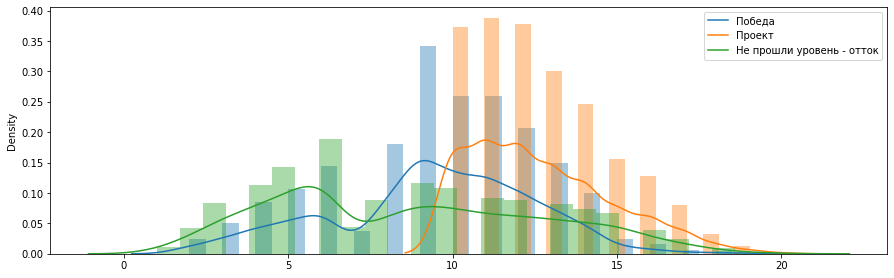

In [49]:
#сравниваем характер распределения количества объектов, в зависимотси от выбранной стратегии
plt.figure(figsize = (15,10))
sns.distplot(build_victory, ax = plt.subplot(2, 1, 1))
sns.distplot(build_project, ax = plt.subplot(2, 1, 1))
sns.distplot(build_churn, ax = plt.subplot(2, 1, 1))
plt.legend(['Победа', 'Проект', 'Не прошли уровень - отток']);

Кажется, что у этих двух стратегий в среднем длительность разная. Но статистический тест в следующем разделе даст научно подкрепленный ответ, что разница в два дня - это статистически значимая разница. Распределения стратегии Проект более плотное.

У категории пользователей, которые не прошли уровень распределение более равномерное, менее плотное. Могли строить разное количество объектов.

In [50]:
#проанализируем, влияет ли источник на выбор одной из двух стратегии
user_strategy = user.groupby('source').agg({'finished_stage_1' : 'count', 'project' : 'count'})
#считаем долю выбравших проект, в общем числе прошедших уровень
user_strategy['strategy'] = user_strategy['project'] / user_strategy['finished_stage_1']
user_strategy

,finished_stage_1,project,strategy
source,,,
facebook_ads,1150,391,0.34
instagram_new_adverts,1466,476,0.32
yandex_direct,2042,620,0.30
youtube_channel_reklama,1159,379,0.33


Если игрок выбирает стратегию **победы**, то в среднем он строит **10 объектов**, но количество построенных объектов это не обязательное условие, можно и с 2мя объектами победить. 

Чтобы пройти уровень посредством **завершения проекта,** нужно построить **как минимум 10 объектов, в среднем строят 12**. 

Для сравнения, **те, кто не прошли первый уровень**, строили **в среднем 8 объектов**, c наиболее часто встречающимся количеством 6. После 6 ти на гистограмме мы видим резкое падение, что означает, видимо, что после этого игрокам становилось неинтересно и они прекращали играть. 

Т.е. получается, чтобы рекламой охватить как можно большую аудиторию нужно показывать рекламу при строительстве первых 10ти объектов. Только нужно, конечно, удостовериться, чтобы она была ненавязчивой и не отпугивала игроков.

Мы посчитали долю выбравших стратегию проекта в прошедших первый уровень в разбивке зависимости от источников. Это тоже важно для оценки эффективности источника, потому что **стратегия проекта** предполагает большее строительство объектов и следовательно больше возможностей для показа рекламы. Т.е чем больше эта доля тем больший потенциал для монетизации. Разброс доли получился от 0.3 до 0.34. Насколько эта разница статистически значимая, нам покажет стат тест в следующем [разделе](#z-test-2)

### Тип построеных объектов

In [51]:
#сделаем сводную таблицу, счетающую количество объектов разного типа, построенных одним игроком
building = game.pivot_table(index='user_id', columns='building_type', values='event_datetime', aggfunc='count')
building = building.fillna(0) #заменяем пропуски на нули для суммирования
building['total'] = building['assembly_shop'] + building['research_center'] + building['spaceport']
#добавим источник 
building = building.merge(source, on='user_id')
#добавим категоризацию 
def cat(user):
    if user in list_victory.index:
        return 'victory' #прошел первый уровень, победив
    if user in list_project.index:
        return 'project' #прошел первый уровень, выполнив проект
    return 'churn' #не прошел первый уровень
building['cat'] = building['user_id'].apply(cat)

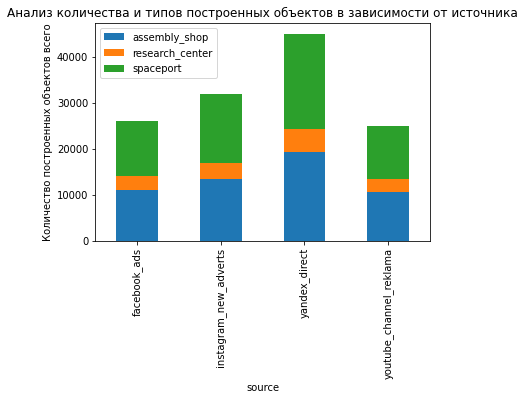

In [52]:
building_type = building.groupby('source').agg({'assembly_shop':'sum', 'research_center':'sum', 'spaceport':'sum'})
building_type.plot(kind='bar', stacked=True)
plt.title('Анализ количества и типов построенных объектов в зависимости от источника')
plt.ylabel('Количество построенных объектов всего');

Соотношение количества построенных объектов в разбивке по источникам аналогично соотношению количеству игроков, привлеченных [разными источниками](#chart-1). Это говорит о том, что пользователи строят примерно одинаковое количество объектов в независимости от источника. 

Больше всего строят spaceport и assembly shop

<div class="alert alert-info"> <b>Комментарий студента:</b> Согласна, с процентами было бы намного полезней. Но то, что я находила в matplotlib, как вставлять проценты - очень муторно, сложно с какими-то дикими циклами. В plotly, тоже какие-то сложности у меня с этим были..... </div> 

<div class="alert alert-success">
<b>Комментарий ревьюера v2:</b>☀️
    
Отлично, что попыталась найти балан по затратам времени и визуальной составляющей
</div>


Распределения количества построенных объектов по типам в зависимости от выбранной стратегии


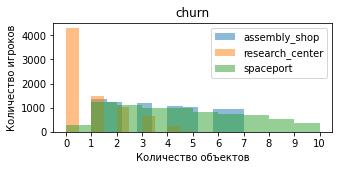

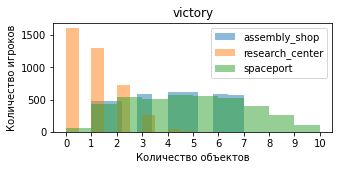

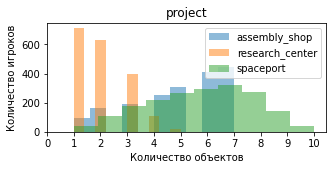

In [53]:
cols = ['assembly_shop', 'research_center', 'spaceport']
cats = building['cat'].unique()
print('Распределения количества построенных объектов по типам в зависимости от выбранной стратегии')
for cat in cats:
    for col in cols:
        building.query('cat==@cat')[col].plot(kind='hist', alpha=0.5, figsize=(5,2), xticks=range(11))
        plt.legend(cols)
        plt.title(cat)
        plt.xlabel('Количество объектов')
        plt.ylabel('Количество игроков')
    plt.show()

В целом те, кто не прошли первый уровень или выбрали стратегию победы над другими игроками имеют похожее распределение по типам объектов. Они или вообще не строят reserach_center или делают это редко. Распределение строительства двух других типов объектов схожее. Различие только в том, что у тех, кто не прошли уровень распределение немного скошено влево. У выбравших победу - более нормальное. Те, кто завершил проект, должны построить хотя бы один research_center и их распределение скошено немного вправо для двух других типов объектов.
У всех игроков количество построенных spaceport не превышает 10, assembly_shop - не больше 7, research_center не больше 5.

### Вывод

Источники различаются по:
* количеству привлеченных пользователей (лидер это Yandex_direct)
* по цене привлечения (самые дешевые это Yandex_direct и Youtube)

Количество дней, проведенное игроком в игре не зависит от источника.

Также мы проанализировали эффективность привлечения пользователей в динамике. Выяснилось, что в первые дни рекламной компании привлекалось больше пользователей и стоимость кликов была меньше, чем в последние дни. Причем падения количества пользователей было очень резким. Из этого можно сделать вывод, что можно сократить сроки размещения рекламы.

Поведения игрока различается от выбора стратегии игры (победа над другими игроками или реализация проекта). Если игрок выбирает проект, то длительность прохождения игры у него увеличивается на 2 дня (от 11 до 13). Также ему приходится строить больше различных объектов - минимум 10. (В среднем 12.) Выбравшие стратегию победы в среднем строят 10 объектов, но могут и меньше.

*В следующем разделе мы проверим гипотезу о том, что время прохождения первого уровня различается в зависимости от стратегии в целом для генеральной совокупности, что полученная разница между выборочными средними статистически значима.*

Т.е. получается, что игроки, выбравшие проект - будут видеть рекламу чаще. 


Мы рассчитали коэффициент удержания - долю прошедших первый уровень. Для разных источников он почти одинаковый.

Также мы рассчитали долю игроков выбравших стратегию реализации проекта в прошедших первый уровень, она также почти не различается для разных источников. *В следующем разделе мы проверим гипотезы о равенстве долей с помощью статистических тестов.*

Также мы оценили категорию игроков, которые не прошли первый уровень. В целом их активность не намного меньше игроков, которые прошли первый уровень, что хорошо для будущей монетизации. Охват аудитории будет большой. Они:
* проводят в игре в среднем 10 дней
* строят в среднем 8 объектов

## Статистический анализ

### Время завершения уровня различается от способа прохождения. 

тест МаннаУитни <a class="anchor" id="time"></a>

В предыдущем [разделе](#MU) мы:
* посчитали среднюю длительность прохождения для каждой из двух стратегий 
* создали два pd.Series для теста МаннаУитни для определения на сколько статистически значимой является разница между двумя этими величинами. 

Теста МаннаУитни был выбран потому, что:
* он может быть использован для выборок разного размера
* выборки могут не быть нормально распределены
* он нечувствителен к выбросам как t-test. (поэтому выбросы не убирали)

**Нулевая гипотеза:** среденнее время, необходимое для прохождения уровня не зависит от выбранной стратегии

**Альтернативная гипотеза:** Игроки выбравшие стратегию завершения проекта, тратят на прохождения первого уровня больше времени, чем игроки выбравшие стратегию победы над другими участниками

**Альфа = 5%.** Если p-value будет меньше уровня значимости, мы отвергнем нулевую гипотезу.

**P-value** - вероятность при которой при данных выборочных средних (11 и 13 дней) генеральные совокупности равны.

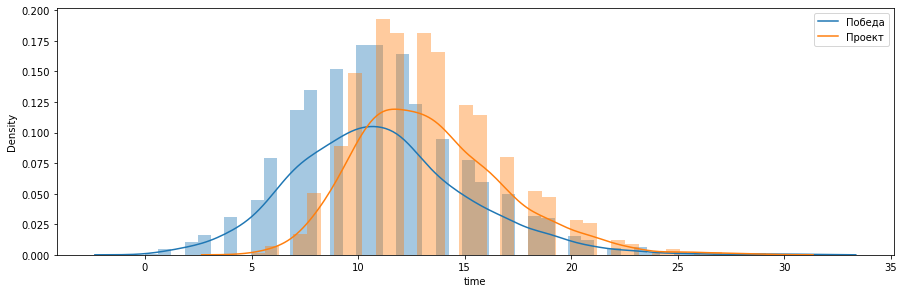

In [54]:
#плотность распределения продолжительности в зависимости от выбранной стратиегии
#сравниваем характер распределения 
plt.figure(figsize = (15,10))
sns.distplot(list_victory, ax = plt.subplot(2, 1, 1))
sns.distplot(list_project, ax = plt.subplot(2, 1, 1))
plt.legend(['Победа', 'Проект']);

In [55]:
#находим p-value теста МаннаУитни
print('p-value:',(stats.mannwhitneyu(list_victory, list_project)[1]))

p-value: 4.7866103584542195e-105


**Вывод.**

**P-value** получается очень маленькое, почти 0, меньше 5% - гипотезу о равенстве длительности прохождения первого уровня у игроков, выбравших разные стратегии отвергаем. Принимаем альтернативную гипотезу. В принципе это и было видно по гистограмам распределения выборочных данных за месяц и выборочным средним.

### Retention_rate не зависит от источника привлечения. 

z-test <a class="anchor" id="z-test-1"></a>

Коэффициент удержания мы посчитали [здесь](#retention). Сравнивать коэффициент удеражние у различных источников мы будем попарно с помощью z-test, тк он представляет собой долю. 

**Z-test** позволяет нам это сделать:
* Выборки, по которым посчитаны доли могут быть разных размеров
* Нормальное распределение выборок не обязательно

**Нулевая гипотеза** - Коэффициенты удеражания разных источников равны между собой. 

**Поправка бонферони.** Тест будет множественным. Количество сравнений будет 6. Чтобы не повысить вероятность ошибки первого рода (отвергнута верная нулевая гипотеза), уровень значимость альфа (мы возьмем 10%) разделим на 6. 

Если посчитанное **p-value** будет меньше уровня значимости - значит есть основания опровергнуть нулевую гипотезу о равенстве долей. 

In [56]:
# функция z-теста
def check_hypothesis (successes1, successes2, trials1, trials2):
    p1 = successes1/trials1
    p2 = successes2/trials2
    p_combined = (successes1 + successes2)/(trials1 + trials2)
    difference = p1 - p2
    z_value = difference / math.sqrt(p_combined*(1 - p_combined)*(1/trials1 + 1/trials2))
    distr = stats.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value)))*2
    return p_value

In [57]:
#сводные данные для теста
user_group

,finished_stage_1,building,project,retention,victory,strategy
source,,,,,,
facebook_ads,1150,2726,391,0.42,0.66,0.34
instagram_new_adverts,1466,3347,476,0.44,0.68,0.32
yandex_direct,2042,4817,620,0.42,0.70,0.30
youtube_channel_reklama,1159,2686,379,0.43,0.67,0.33


In [58]:
alpha_bonferoni = round(0.1/6, 2)
print('alpha_bonferoni:', alpha_bonferoni)

alpha_bonferoni: 0.02


In [59]:
#создаем пары из четырех источников для сравнения долей
pairs = list(itertools.combinations(user_group.index, 2))

#применяем z-test к каждой паре
for pair in pairs:
    print(pair[0], ' and ', pair[1])
    print('p-value:', '{0:.2f}'.format(check_hypothesis(user_group.loc[pair[0], 'finished_stage_1'],\
                user_group.loc[pair[1], 'finished_stage_1'],\
                user_group.loc[pair[0], 'building'],\
                user_group.loc[pair[1], 'building'])))
    print('\n')

facebook_ads  and  instagram_new_adverts
p-value: 0.21


facebook_ads  and  yandex_direct
p-value: 0.86


facebook_ads  and  youtube_channel_reklama
p-value: 0.47


instagram_new_adverts  and  yandex_direct
p-value: 0.21


instagram_new_adverts  and  youtube_channel_reklama
p-value: 0.61


yandex_direct  and  youtube_channel_reklama
p-value: 0.52




**Вывод.**

Все полученные **p-value** больше уровня значимости с поправкой бонферони - не отвергаем нулевую гипотезу о равенстве долей. Коэффициент удержания не зависит от выбранного источника.

### Выбор стратегии пользователем не зависит от канала привлечения. 

z-test <a class="anchor" id="z-test-2"></a>

Долю выбравших проект, в общем количестве прошедших первый уровень мы посчитали [здесь](#project_ratio). Этот коэффициент мы сравним с помощью z-test у всех источников попарно. Расчеты будут аналогичные как и у z-test retention_rate. 

**Нулевая гипотеза** - Доля выбравших стратегию завершения проекта разных источников одинакова для всех источников.

In [60]:
#создаем пары из четырех источников для сравнения долей
#применяем z-test к каждой паре
for pair in pairs:
    print(pair[0], ' and ', pair[1])
    print('p-value:', '{0:.2f}'.format(check_hypothesis(user_group.loc[pair[0], 'project'],\
                user_group.loc[pair[1], 'project'],\
                user_group.loc[pair[0], 'finished_stage_1'],\
                user_group.loc[pair[1], 'finished_stage_1'])))
    print('\n')

facebook_ads  and  instagram_new_adverts
p-value: 0.41


facebook_ads  and  yandex_direct
p-value: 0.03


facebook_ads  and  youtube_channel_reklama
p-value: 0.51


instagram_new_adverts  and  yandex_direct
p-value: 0.18


instagram_new_adverts  and  youtube_channel_reklama
p-value: 0.90


yandex_direct  and  youtube_channel_reklama
p-value: 0.17




**Вывод.**

Все полученные **p-value** больше уровня значимости с поправкой бонферони - не отвергаем нулевую гипотезу о равенстве долей. Выбор стратегии не зависит от выбранного источника.

## Вывод

In [61]:
display(user_group_ratios)

,retention,strategy,cost_per_user
source,,,
facebook_ads,0.42,0.34,0.79
instagram_new_adverts,0.44,0.32,0.65
yandex_direct,0.42,0.30,0.46
youtube_channel_reklama,0.43,0.33,0.40


***Какой источник лучше с точки зрения эффективности?***
Мы выяснили, что источники значимо различаются только ценой привлечения юзера. Выбор источника привлечения не влияет на коэффициент удержания(прохождения уровня). Также не влияет на выбор стратегии, которая будет использоваться игроком. Т.е. не будет влиять ни на длительность прохождения уровня, ни на количество построенных объектов. Следовательно, нужно выбирать самые дешевые источники - Yandex и Youtube.

***Размещение рекламы.***
В среднем игрок на превом уровне строит от 8 (не прошли уровень) до 12 (реализация проекта) объектов. При среднем времени прохождения первого уровня от 11 до 13 дней. Также игрок, который вообще не прошел уровнеь остается в игре в среднем 10 дней. Поэтому показывать рекламу при каждом выборе объекта для строительства является хорошим выбором. Это происходит в среднем менее двух раз за день и реклама не будет слишком частой и навязчивой.

Выручка от размещения рекламы приходящаяся на одного пользователя не должна быть меньше стоимости его привлечения.